# Chains and Binding tools with LLM

In this notebook, we are going to explore about the following: 
- Messages (LangChain)
- Tools binding with LLM (LangChain)
- add_messages reducer

Combining above all three in form of graph looking like a chain.

## Initializing LLM

In [1]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")
llm.invoke("Hello wold!")

AIMessage(content='Hello there! It seems like you\'re trying to greet the world! While I\'m happy to chat with you, I should let you know that the correct phrase is actually "Hello, world!" Not to worry, though - I\'m here to help and happy to chat with you regardless! What\'s on your mind?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 14, 'total_tokens': 79, 'completion_time': 0.068722543, 'prompt_time': 0.005327103, 'queue_time': 0.511992418, 'total_time': 0.074049646}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'finish_reason': 'stop', 'logprobs': None}, id='run--ff2aea85-2068-4abd-bf74-fd5ef2876b81-0', usage_metadata={'input_tokens': 14, 'output_tokens': 65, 'total_tokens': 79})

## Messages 

We have mainly two types of messages in LangChain. 
- AI Message
- Human Message

Note: All the messages should be stored in a python list and should be passed to the LLM for invocation.

Below is an example conversation happening between LLM and Human

In [2]:
from langchain_core.messages import HumanMessage, AIMessage

initial_messages = [AIMessage(content="So we are discussing about the special dishes in India! Which dish you would like to know more about?", name="model"), 
                    HumanMessage(content="I would like to know about Biryani!", name="Sai Kiran"),
                    AIMessage(content="Biryani is a mixed rice dish originating among the Muslims of the Indian subcontinent as a variety of Persian pilaf. It is made with Indian spices, rice, and usually some type of meat (chicken, beef, lamb, goat, prawn, fish etc.) or sometimes eggs or potatoes.", name="model")]

new_message = HumanMessage(content="What is the origin of Biryani?", name="Sai Kiran")

initial_messages.append(new_message)

for m in initial_messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: model

So we are discussing about the special dishes in India! Which dish you would like to know more about?
================================ Human Message =================================
Name: Sai Kiran

I would like to know about Biryani!
================================== Ai Message ==================================
Name: model

Biryani is a mixed rice dish originating among the Muslims of the Indian subcontinent as a variety of Persian pilaf. It is made with Indian spices, rice, and usually some type of meat (chicken, beef, lamb, goat, prawn, fish etc.) or sometimes eggs or potatoes.
================================ Human Message =================================
Name: Sai Kiran

What is the origin of Biryani?


Let's try to pass the conversation, and see how the LLM responds back to my recent Human message.

In [3]:
response_from_llm = llm.invoke(initial_messages + [new_message])
initial_messages.append(response_from_llm) # append the response to the conversation

# Printing the whole conversation
for m in initial_messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: model

So we are discussing about the special dishes in India! Which dish you would like to know more about?
================================ Human Message =================================
Name: Sai Kiran

I would like to know about Biryani!
================================== Ai Message ==================================
Name: model

Biryani is a mixed rice dish originating among the Muslims of the Indian subcontinent as a variety of Persian pilaf. It is made with Indian spices, rice, and usually some type of meat (chicken, beef, lamb, goat, prawn, fish etc.) or sometimes eggs or potatoes.
================================ Human Message =================================
Name: Sai Kiran

What is the origin of Biryani?
================================== Ai Message ==================================

The origin of Biryani is a topic of much debate and controversy. There are several claims about its orig

## Tools Initialization and binding with LLM

As we all know that LLMs are not good in Mathematical calculations, hence let us try to create a basic function which does Multiplication and bind the same with LLM using `bind_tools()` function. 

In [4]:
def multiply(a: int, b: int) -> int:
    # Below docstring is used to generate the function signature in the LLM response.
    """Multiplies two integers.
    
    args:
        a (int): The first integer.
        b (int): The second integer.
        
    returns:
        int: The product of the two integers."""
    
    return a * b

Binding the above tool with our LLM

In [5]:
llm_with_tool = llm.bind_tools([multiply])

response_with_tool = llm_with_tool.invoke("What is 30 multiplied by 20?")
response_with_tool.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (ybdjk5amr)
 Call ID: ybdjk5amr
  Args:
    a: 30
    b: 20


## Understanding about Reducers and `MessagesState`

As we discussed in the previous notebook, the variable in our `state` was overriden after every node invocation. But in terms of messages, we **do not want** to get it overriden as it will lose our previous context/interaction with the LLM. 

Hence, it is required to find a way where we need to append the messages after each and every interaction. To achieve this, we need to leverage the help of Reducers functionality

### About Reducers

- Reducers specify how the state updates should be performed.

- If no reducer function is specified, it is assumed that state key values will get overriden by default.
- But to append the messages in the conversation, we can use the pre-built functionality of `add_messages`.
- This reducer ensures any type of message gets appended to the previous list of messages automatically. 
- To acheive this, we simply need to `Annotate` our messages variable with the add_messages reducer function as metadata.

### Testing add_messages reducer in isolation

In [6]:
from langgraph.graph.message import add_messages

# Initial messages stored 
initial_messages = [AIMessage(content="Hello! How can I assist you today?", name="model"),
                    HumanMessage(content="What is the weather like today?", name="User")]

# next message to be added
next_message = AIMessage(content="The weather in Bengaluru is likely feeling cold yet sunny", name="model")

# using the add_message reducer from langgraph
add_messages(initial_messages, next_message)    

[AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, name='model', id='d82eebd5-a259-4a6c-9c68-c42ea606c77f'),
 HumanMessage(content='What is the weather like today?', additional_kwargs={}, response_metadata={}, name='User', id='c87bfb9b-6c3d-42bd-8e48-a07f6582d4bc'),
 AIMessage(content='The weather in Bengaluru is likely feeling cold yet sunny', additional_kwargs={}, response_metadata={}, name='model', id='d41e5397-fb4b-4151-87e1-8c22f3ee5c06')]

In [7]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages, AnyMessage

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] # This will allow us to append messages to the state

Instead of defining the same above everytime, LangGraph has a built-in `MessagesState` where the messages variable along with the add_messages reducer comes by default, and we can define the remaining schema as always. 

`MessagesState` is defined with the following: 
- messages as pre-build State key
- accepts list of AnyMessage
- add_messages reducer ensures all messages are appended to the previous list of messages

In [8]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built already for us
    pass

Now, lets combine all the things we learned so far and build a graph

## Building Graph with `tool_calling_llm` and `MessagesState`

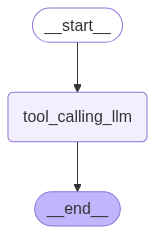

In [9]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.graph.message import add_messages, AnyMessage 

# Define the state
# class MessagesState(MessagesState):
#     pass

class State(TypedDict):
    messages: Annotated[list, add_messages]  # This will allow us to append messages to the state

# Define a single node which returns response from the LLM based on the message in the state
def tool_calling_llm(messagesState: State):
    return { "messages" : llm_with_tool.invoke([messagesState["messages"]]) }

# Define the state graph
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

# Create the graph
graph = builder.compile()

graph

### Invoking the graph

In [10]:
messages = [HumanMessage(content="What is 30 multiplied by 20?")]
response = graph.invoke({"messages" : messages })

NotImplementedError: Unsupported message type: <class 'list'>
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/MESSAGE_COERCION_FAILURE 